### Deep Learning

#### Primary/Preliminary Exploration of DL Models

It is important to note that the dataset used in this analysis underwent all necessary preprocessing steps, ensuring it was fully prepared for direct application in the evaluated models.  

This notebook presents an exploration of different deep learning models for addressing a specific problem. The goal is to compare model architectures, analyze performance, and identify the most suitable approach.

**Note:** This is not a document for evaluation. This document served as the basis for the subsequent construction of section 4 of the work. The objective was to carry out a general exploration of the models and, based on the most promising ones, try to optimize them.


##### Objective

The primary objectives are:
- Evaluate various neural network architectures (Dense NN, Conv1D, LSTM, Autoencoder).
- Compare their performance using key metrics.
- Analyze overfitting and generalization.

In [2]:
# Import necessary packages
from tdc.multi_pred import GDA
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import pdist, squareform

# Read the CSV file
final_df_ML = pd.read_csv('final_df_ML.csv')

# Separate features (X) and target (y)
# Features: 'Seq_Embedding' and 'Disease_Embedding'
# Target: 'Y'

X = final_df_ML[['Seq_Embedding', 'Disease_Embedding']]  # Extract features
y = final_df_ML['Y']  # Extract target

# Split the dataset into training + validation and testing sets (80% train + validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train + validation set into training and validation sets (80% train, 20% validation)
# Note: 0.25 x 0.8 = 0.2, which maintains the overall 20% validation size
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Display the shape of the datasets for verification
print(f'Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}')

# Convert string representations of embeddings to numeric arrays
# Disease embedding
X_train['Disease_Embedding'] = X_train['Disease_Embedding'].apply(
    lambda x: np.array(x.strip('[]').split(), dtype=float)
)
X_val['Disease_Embedding'] = X_val['Disease_Embedding'].apply(
    lambda x: np.array(x.strip('[]').split(), dtype=float)
)
X_test['Disease_Embedding'] = X_test['Disease_Embedding'].apply(
    lambda x: np.array(x.strip('[]').split(), dtype=float)
)

# Sequence embedding
X_train['Seq_Embedding'] = X_train['Seq_Embedding'].apply(
    lambda x: np.array(x.strip('[]').split(), dtype=float)
)
X_val['Seq_Embedding'] = X_val['Seq_Embedding'].apply(
    lambda x: np.array(x.strip('[]').split(), dtype=float)
)
X_test['Seq_Embedding'] = X_test['Seq_Embedding'].apply(
    lambda x: np.array(x.strip('[]').split(), dtype=float)
)

# Concatenate sequence and disease embeddings
X_train_embeddings = np.hstack([X_train['Seq_Embedding'].tolist(), X_train['Disease_Embedding'].tolist()])
X_val_embeddings = np.hstack([X_val['Seq_Embedding'].tolist(), X_val['Disease_Embedding'].tolist()])
X_test_embeddings = np.hstack([X_test['Seq_Embedding'].tolist(), X_test['Disease_Embedding'].tolist()])

# Verify the shape of the concatenated feature matrix
# This ensures that the embeddings are combined into a single matrix for further processing
print(f'Shape of the feature matrix before PCA: {X_train_embeddings.shape}')

Train shape: (31485, 2), Validation shape: (10495, 2), Test shape: (10496, 2)
Shape of the feature matrix before PCA: (31485, 868)


#### Model Construction

Four architectures were evaluated:

1. **Dense Neural Network (Dense NN)**: Basic feedforward network for capturing general patterns.
2. **Conv1D**: Designed for spatial feature extraction.
3. **LSTM**: Focused on sequential data processing.
4. **Autoencoder**: Aimed at dimensionality reduction and feature extraction.


##### Dense NN Model (v1):  

- Regularization with Dropout
- Batch Normalization
- Optimization with Adam
- Early Stopping
- Batch Size - 32

In [ ]:
# Define a function to build the Dense Neural Network model
def build_model_v1(input_dim):
    model = Sequential([
        # First dense layer with 256 neurons and ReLU activation
        Dense(256, activation='relu', input_dim=input_dim),
        # Batch normalization to stabilize and accelerate training
        BatchNormalization(),
        # Dropout for regularization (30% of neurons will be dropped)
        Dropout(0.3),
        
        # Second dense layer with 128 neurons and ReLU activation
        Dense(128, activation='relu'),
        # Batch normalization for this layer
        BatchNormalization(),
        # Dropout for regularization (30% of neurons will be dropped)
        Dropout(0.3),
        
        # Third dense layer with 64 neurons and ReLU activation
        Dense(64, activation='relu'),
        # Batch normalization for this layer
        BatchNormalization(),
        # Dropout for regularization (20% of neurons will be dropped)
        Dropout(0.2),
        
        # Output layer with a single neuron for regression (no activation function)
        Dense(1)
    ])
    return model

# Build the model with the input dimension of the prepared training data
model_v1 = build_model_v1(input_dim=X_train_prepared.shape[1])

# Compile the model
# - Optimizer: Adam with a learning rate of 0.001 for efficient and adaptive gradient updates
# - Loss function: Mean Squared Error (MSE) as this is a regression task
# - Metric: Mean Squared Error (MSE) to monitor model performance during training
model_v1.compile(optimizer=Adam(learning_rate=0.001), 
                 loss='mean_squared_error', 
                 metrics=['mean_squared_error'])

# Train the model
# - Training data: X_train_prepared (features) and y_train (target)
# - Validation data: X_val_prepared (features) and y_val (target)
# - Epochs: 100 (maximum number of training iterations)
# - Batch size: 32 (number of samples per gradient update)
# - Callbacks: Early stopping to halt training when validation performance stops improving
# - Verbosity: 1 (displays progress during training)
history_v1 = model_v1.fit(X_train_prepared, y_train, 
                          validation_data=(X_val_prepared, y_val), 
                          epochs=100, 
                          batch_size=32, 
                          callbacks=[early_stopping], 
                          verbose=1)


Epoch 1/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5578 - mean_squared_error: 0.5578 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 2/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0390 - mean_squared_error: 0.0390 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 3/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 4/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.3040 - val_mean_squared_error: 0.3040
Epoch 5/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 6/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 1.5200 - val_mean_squared_error: 1.5200
Epoch 7/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_los

##### Conv1D Model (v2)  

- Convolutional Layers (Conv1D).
- MaxPooling1D layers were used, capturing the most relevant patterns.
- Dropout was applied after each convolutional block to prevent overfitting. 
- Flatten layer.
    - An intermediate dense layer with 64 units was added to capture global relationships in the processed data.
    - The output layer consists of a single unit (continuous value), appropriate for regression.

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Define a function to build the 1D Convolutional Neural Network model
def build_model_v2(input_dim):
    model = Sequential([
        # First convolutional layer with 64 filters, kernel size of 3, and ReLU activation
        Conv1D(64, 3, activation='relu', input_shape=(input_dim, 1)),
        # MaxPooling1D to reduce dimensionality and extract the most important features
        MaxPooling1D(),
        # Dropout for regularization (30% of neurons dropped)
        Dropout(0.3),
        
        # Second convolutional layer with 128 filters, kernel size of 3, and ReLU activation
        Conv1D(128, 3, activation='relu'),
        # MaxPooling1D for further dimensionality reduction
        MaxPooling1D(),
        # Dropout for regularization (30% of neurons dropped)
        Dropout(0.3),
        
        # Flatten layer to convert the 2D outputs of convolutional layers into a 1D format
        Flatten(),
        
        # Fully connected dense layer with 64 neurons and ReLU activation
        Dense(64, activation='relu'),
        # Dropout for regularization (20% of neurons dropped)
        Dropout(0.2),
        
        # Output layer with a single neuron for regression (no activation function)
        Dense(1)
    ])
    return model

# Prepare the data for the CNN
# CNNs require 3D input (samples, time steps, features), so we expand the dimensions of the input data
X_train_prepared_cnn = np.expand_dims(X_train_prepared, axis=-1)
X_val_prepared_cnn = np.expand_dims(X_val_prepared, axis=-1)
X_test_prepared_cnn = np.expand_dims(X_test_prepared, axis=-1)

# Build the model with the input dimension of the prepared training data
model_v2 = build_model_v2(input_dim=X_train_prepared.shape[1])

# Compile the model
# - Optimizer: Adam with a learning rate of 0.001 for adaptive learning
# - Loss function: Mean Squared Error (MSE), suitable for regression tasks
# - Metric: Mean Squared Error (MSE) to track performance during training
model_v2.compile(optimizer=Adam(learning_rate=0.001), 
                 loss='mean_squared_error', 
                 metrics=['mean_squared_error'])

# Train the model
# - Training data: X_train_prepared_cnn (features) and y_train (target)
# - Validation data: X_val_prepared_cnn (features) and y_val (target)
# - Epochs: 100 (maximum number of training iterations)
# - Batch size: 32 (number of samples per gradient update)
# - Callbacks: Early stopping to halt training if validation performance stops improving
# - Verbosity: 1 (displays progress during training)
history_v2 = model_v2.fit(X_train_prepared_cnn, y_train, 
                          validation_data=(X_val_prepared_cnn, y_val), 
                          epochs=100, 
                          batch_size=32, 
                          callbacks=[early_stopping], 
                          verbose=1)

Epoch 1/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - loss: 0.4053 - mean_squared_error: 0.4053 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 2/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 3/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 4/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 5/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 64s 65ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 6/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 7/100
984/984 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 0.0367 - mean_squared_error: 0.

##### LSTM Model (v3)

- LSTM with 32 and 16 Units.
- Dropout Regularization
- Dense Output Layer:
    - A single unit in the output layer (Dense(1)) was configured to predict continuous values, with the output type specified as float32 to avoid issues with mixed precision.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import numpy as np

# Enable mixed precision training for faster computations on compatible hardware
# Mixed precision uses float16 for operations and float32 for model weights
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define a function to build the LSTM-based model
def build_model_v3(input_dim):
    model = Sequential([
        # First LSTM layer with 32 units, returning sequences for stacking another LSTM
        LSTM(32, input_shape=(input_dim, 1), return_sequences=True),
        # Dropout for regularization (20% of neurons dropped)
        Dropout(0.2),
        
        # Second LSTM layer with 16 units, not returning sequences (last output only)
        LSTM(16, return_sequences=False),
        # Dropout for regularization (10% of neurons dropped)
        Dropout(0.1),
        
        # Output layer with a single neuron for regression (uses float32 precision for stability)
        Dense(1, dtype='float32')
    ])
    return model

# Prepare data for LSTM
# LSTMs require 3D input (samples, time steps, features), so we expand the dimensions of the input data
X_train_prepared_lstm = np.expand_dims(X_train_prepared, axis=-1)
X_val_prepared_lstm = np.expand_dims(X_val_prepared, axis=-1)
X_test_prepared_lstm = np.expand_dims(X_test_prepared, axis=-1)

# To speed up training, use a sample of the training data
X_train_sample = X_train_prepared_lstm[:10000]
y_train_sample = y_train[:10000]

# Build the model with the input dimension of the prepared training data
model_v3 = build_model_v3(input_dim=X_train_prepared.shape[1])

# Compile the model
# - Optimizer: Adam with a learning rate of 0.001 for efficient adaptive updates
# - Loss function: Mean Squared Error (MSE), suitable for regression tasks
# - Metric: Mean Squared Error (MSE) to monitor performance during training
model_v3.compile(optimizer=Adam(learning_rate=0.001), 
                 loss='mean_squared_error', 
                 metrics=['mean_squared_error'])

# Configure EarlyStopping
# - Monitor: Validation loss (`val_loss`)
# - Patience: Stop training if validation loss doesn't improve for 5 consecutive epochs
# - Restore Best Weights: Use the best model weights obtained during training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
# - Training data: A subset of `X_train_prepared_lstm` and `y_train` for faster experimentation
# - Validation data: Full validation dataset
# - Epochs: 30 (maximum number of training iterations)
# - Batch size: 32 (smaller batch size for LSTM stability)
# - Callbacks: Early stopping to halt training if validation loss stops improving
# - Verbosity: 1 (displays progress during training)
history_v3 = model_v3.fit(X_train_sample, y_train_sample, 
                          validation_data=(X_val_prepared_lstm, y_val), 
                          epochs=30, 
                          batch_size=32, 
                          callbacks=[early_stopping], 
                          verbose=1)


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 423ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 410ms/step - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 402ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 375ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 150s 479ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 116s 372ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 374ms/step - loss: 0.0364 - mean_squared_er

##### Autoencoder Model (v4)

- The Autoencoder starts with an input layer, which has the same number of neurons as the features in the dataset (input_dim).

- Encoding (Encoder):
    - Dense layers gradually reduce the dimensionality.
    - BatchNormalization

- Decoding (Decoder):
        - Dense(128, relu).
        - Dense(input_dim, sigmoid).
    - The sigmoid activation in the final layer.

- Autoencoder Compilation:
    - Uses Adam as the optimizer and mean_squared_error as the loss function.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to build the Autoencoder
def build_autoencoder(input_dim):
    # Input layer with the same number of neurons as the dataset's features
    input_layer = Input(shape=(input_dim,))
    
    # Encoding layers
    # First encoding layer with 128 neurons and ReLU activation
    encoded = Dense(128, activation='relu', dtype='float32')(input_layer)
    # Batch normalization to stabilize values and accelerate training
    encoded = BatchNormalization()(encoded)
    # Second encoding layer with 64 neurons and ReLU activation
    encoded = Dense(64, activation='relu', dtype='float32')(encoded)
    # Batch normalization for the second layer
    encoded = BatchNormalization()(encoded)
    
    # Decoding layers
    # First decoding layer with 128 neurons and ReLU activation
    decoded = Dense(128, activation='relu', dtype='float32')(encoded)
    # Batch normalization for the decoding layer
    decoded = BatchNormalization()(decoded)
    # Output layer with `input_dim` neurons and sigmoid activation for normalized reconstruction
    decoded = Dense(input_dim, activation='sigmoid', dtype='float32')(decoded)
    
    # Build the Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    # Compile the Autoencoder using Adam optimizer and MSE loss
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    return autoencoder

# Function to build the Model v4 using the Autoencoder
def build_model_v4(input_dim):
    # Build the Autoencoder
    autoencoder = build_autoencoder(input_dim)
    # Extract the encoder part (first four layers) from the Autoencoder
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)
    
    # Build a regression model using the encoded representations
    model = Sequential([
        encoder,  # Use the encoder as the first part of the regression model
        Dense(64, activation='relu', dtype='float32'),  # Dense layer with 64 neurons
        BatchNormalization(),  # Batch normalization to stabilize training
        Dropout(0.3),  # Dropout for regularization (30% of neurons dropped)
        Dense(1, dtype='float32')  # Output layer with one neuron for regression
    ])
    return model

# Train the Autoencoder
# - Training data: `X_train_embeddings` as both input and target for reconstruction
# - Epochs: 50 to allow sufficient training for reconstruction
# - Batch size: 32 for efficient processing
autoencoder_v4 = build_autoencoder(input_dim=X_train_embeddings.shape[1])
autoencoder_v4.fit(X_train_embeddings, X_train_embeddings, epochs=50, batch_size=32, verbose=1)

# Train the regression model
# Build Model v4
model_v4 = build_model_v4(input_dim=X_train_embeddings.shape[1])
# Compile the model
# - Optimizer: Adam with a learning rate of 0.001
# - Loss: Mean Squared Error (MSE) for regression
# - Metric: Mean Squared Error (MSE) to track performance
model_v4.compile(optimizer=Adam(learning_rate=0.001), 
                 loss='mean_squared_error', 
                 metrics=['mean_squared_error'])

# Configure callbacks
# - EarlyStopping: Stops training if validation loss doesn't improve for 5 consecutive epochs
# - ReduceLROnPlateau: Reduces the learning rate by a factor of 0.2 if validation loss stagnates for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train Model v4
# - Training data: `X_train_embeddings` (features) and `y_train` (target)
# - Validation data: `X_val_embeddings` (features) and `y_val` (target)
# - Epochs: 100 (maximum training iterations)
# - Batch size: 32 for efficient training
# - Callbacks: EarlyStopping and ReduceLROnPlateau for better training control
history_v4 = model_v4.fit(X_train_embeddings, y_train, 
                          validation_data=(X_val_embeddings, y_val), 
                          epochs=100, 
                          batch_size=32, 
                          callbacks=[early_stopping, reduce_lr], 
                          verbose=1)


Epoch 1/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0402
Epoch 2/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.0883e-04
Epoch 3/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.2458e-04
Epoch 4/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7250e-04
Epoch 5/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.4178e-04
Epoch 6/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1769e-04
Epoch 7/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.0003e-04
Epoch 8/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8908e-04
Epoch 9/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8348e-04
Epoch 10/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.6753e-04
Epoch 11/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.6444e-04
Epoch 12/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.6099e-04
Epoch 13/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.5428e-04
Epoch 14/50
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.5196e-04
Epoch

##### LSTM (Improved)

Main Differences of LTSM (Improved) comparing with LSTM(v3):  

| **parameter**               | **improved_lstm**                                | **LSTM(v3)**                               |
|---------------------------|--------------------------------------------------|--------------------------------------------|
| **Activation Functions**  | Explicitly uses `tanh` and `sigmoid`.            | Defaults to `tanh` and `sigmoid` (not explicit). |
| **Batch Normalization**   | Applied after each LSTM layer.                   | Not used.                                  |
| **Dense Layer**           | Adds a dense layer (8 neurons, ReLU).            | No dense layer included.                   |
| **Dropout**               | Applied after LSTM and dense layers (20%, 10%, 10%). | Only after LSTM layers (20%, 10%).         |
| **Precision**             | `mixed_float16` with output in `float32`.        | `mixed_float16` without output adjustments.|
| **Epochs**                | 10 epochs (faster training).                     | 30 epochs.                                 |
| **Callbacks**             | **EarlyStopping** and **ReduceLROnPlateau**.    | Only **EarlyStopping**.                    |
| **Training Data**         | Full dataset (`X_train_prepared_lstm`).  



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Enable Mixed Precision to speed up training on compatible hardware
# Mixed precision uses float16 for computations and float32 for model weights
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Function to build the improved LSTM model
def build_improved_lstm(input_dim):
    model = Sequential([
        # First LSTM layer with 32 units
        # - Activation: Tanh for input transformation and sigmoid for recurrent state updates
        # - return_sequences=True allows the output to be a sequence for the next LSTM layer
        LSTM(32, input_shape=(input_dim, 1), return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
        # Batch normalization to stabilize training and improve performance
        BatchNormalization(),
        # Dropout for regularization (20% of neurons dropped)
        Dropout(0.2),
        
        # Second LSTM layer with 16 units
        # - return_sequences=False produces a fixed-length output for the dense layers
        LSTM(16, return_sequences=False, activation='tanh', recurrent_activation='sigmoid'),
        # Batch normalization for the second LSTM layer
        BatchNormalization(),
        # Dropout for regularization (10% of neurons dropped)
        Dropout(0.1),
        
        # Dense layer with 8 neurons and ReLU activation to capture higher-level features
        Dense(8, activation='relu'),
        # Dropout for regularization (10% of neurons dropped)
        Dropout(0.1),
        
        # Output layer with a single neuron for regression
        Dense(1, dtype='float32')
    ])
    return model

# Prepare data for LSTM
# LSTMs require 3D input (samples, time steps, features), so we expand the dimensions of the input data
X_train_prepared_lstm = np.expand_dims(X_train_prepared, axis=-1)
X_val_prepared_lstm = np.expand_dims(X_val_prepared, axis=-1)

# Build the improved LSTM model
lstm_model = build_improved_lstm(input_dim=X_train_prepared.shape[1])

# Compile the model
# - Optimizer: Adam with a learning rate of 0.001 for efficient and adaptive updates
# - Loss function: Mean Squared Error (MSE), suitable for regression tasks
# - Metric: Mean Squared Error (MSE) to monitor performance during training
lstm_model.compile(optimizer=Adam(learning_rate=0.001), 
                   loss='mean_squared_error', 
                   metrics=['mean_squared_error'])

# Configure callbacks
# - EarlyStopping: Stops training if validation loss doesn't improve for 10 consecutive epochs
# - ReduceLROnPlateau: Reduces the learning rate by a factor of 0.5 if validation loss stagnates for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train the model
# - Training data: `X_train_prepared_lstm` (features) and `y_train` (target)
# - Validation data: `X_val_prepared_lstm` (features) and `y_val` (target)
# - Epochs: 10 to prevent overfitting and speed up training during experimentation
# - Batch size: 32 for efficient memory utilization and training
# - Callbacks: EarlyStopping and ReduceLROnPlateau to improve training efficiency
# - Verbosity: 1 displays progress during training
history_lstm = lstm_model.fit(
    X_train_prepared_lstm, y_train,
    validation_data=(X_val_prepared_lstm, y_val),
    epochs=10,  # Reduced number of epochs for faster experimentation
    batch_size=32,  # Suitable batch size for LSTM processing
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 386s 391ms/step - loss: 0.0802 - mean_squared_error: 0.0802 - val_loss: 0.0525 - val_mean_squared_error: 0.0525 - learning_rate: 0.0010
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 366s 372ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - learning_rate: 0.0010
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 357s 363ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - learning_rate: 0.0010
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 517s 501ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - learning_rate: 0.0010
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 401s 407ms/step - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - learning_rate: 0.0010
Epoch 6/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 401s 407ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0765 -

#### Results and Observations

The results highlight differences in train and validation loss across models. The Dense NN, Conv1D, LSTM, and Autoencoder models showed varying levels of performance, with LSTM generalizing better to sequential data.


##### Dense NN (Dense Neural Network)

Points to Observe:

- If the `val_loss` increases while the `train_loss` decreases, it may indicate overfitting.
- If both losses remain high, it could mean the model is underfitting and requires further adjustments to the hyperparameters.


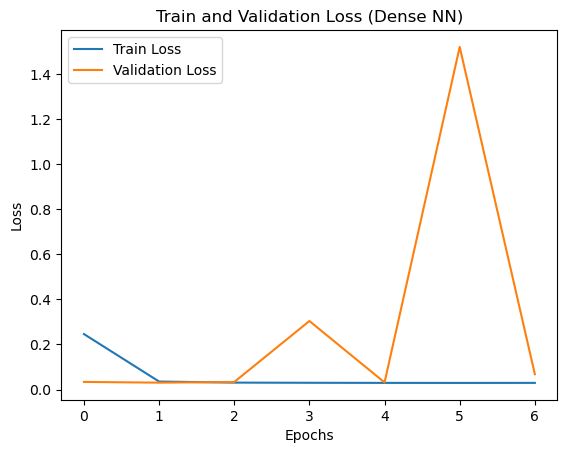

In [ ]:
# Visualização para Dense NN (history_v1)
plt.plot(history_v1.history['loss'], label='Train Loss')
plt.plot(history_v1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss (Dense NN)')
plt.show()


Interpretation:

- **Evident Overfitting**.
- The disparity between the curves suggests that the model is not generalizing adequately. Possible causes include:
    - **Excessive Model Capacity**
    - **Lack of Regularization**


##### Conv1D (1D Convolutional Neural Network)

Points to Observe:

- If the `train_loss` is very low and the `val_loss` is high, it may indicate that the model is overly fitted to the training set.
- If both losses decrease consistently, it suggests good fitting and learning.

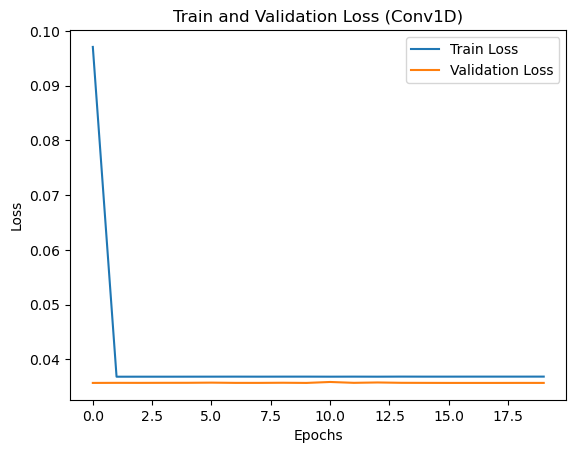

In [ ]:

# Visualization Conv1D (history_v2)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss (Conv1D)')
plt.show()


Interpretation:

- **Very Good Fit**: The validation curve is stable and very close to the training loss, indicating that the model is learning well without overfitting.
- The Conv1D appears to be well-suited for the data, likely due to its ability to identify local patterns in sequential data.

##### LSTM (Recurrent Neural Network - Long Short-Term Memory)

Points to Observe:

- Fluctuations in validation loss are normal at the beginning but should stabilize over time.
- If the `train_loss` is consistently lower than the `val_loss`, it may be necessary to increase regularizers, such as dropout, to prevent overfitting.


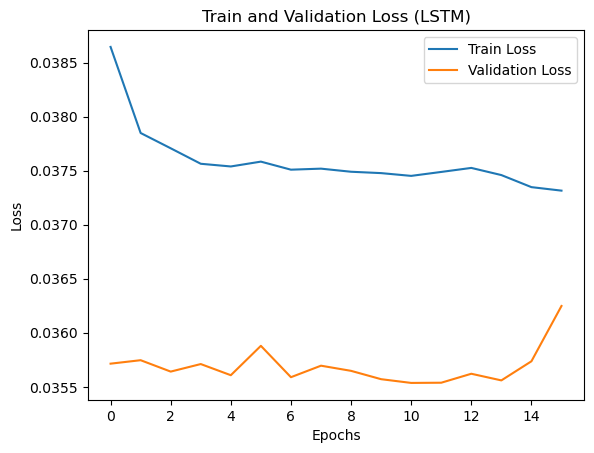

In [ ]:

# Visualization LSTM (history_v3)
plt.plot(history_v3.history['loss'], label='Train Loss')
plt.plot(history_v3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss (LSTM)')
plt.show()


Interpretation:

- **Good Fit**: The small difference between Train Loss and Validation Loss indicates that the model is learning to generalize well.
- The oscillations in Validation Loss are normal for LSTMs due to the complex nature of temporal learning.

##### Autoencoder

Points to Observe:

- If the `val_loss` increases rapidly, it may indicate that the model is not learning a generalizable representation.
- Consistent differences between `train_loss` and `val_loss` may suggest the need to adjust the model's capacity or apply regularization.


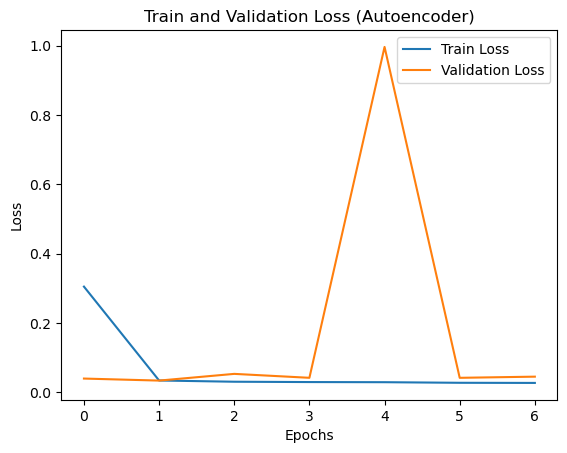

In [ ]:

# Visualization Autoencoder (history_v4)
plt.plot(history_v4.history['loss'], label='Train Loss')
plt.plot(history_v4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss (Autoencoder)')
plt.show()


Interpretation:

- **Insufficient Generalization**: The oscillations in Validation Loss indicate that the model is struggling to learn a generalizable representation of the data.
- The autoencoder may be memorizing the training set instead of capturing global patterns.

##### LSTM (improved) vs LSTM (v3) 

| Feature               | LSTM (improved)                        | LSTM (v3)                      |
|-----------------------|---------------------------------------|-------------------------------|
| Activation Functions  | Explicitly sets tanh and sigmoid      | Defaults to tanh and sigmoid  |
| Batch Normalization   | Yes                                   | No                            |
| Dense Layers          | Includes an additional dense layer    | No additional dense layer     |
| Dropout               | Applied after dense layer             | No dropout after dense layer  |
| Mixed Precision       | Fully utilized with output stability  | Basic mixed precision         |
| Epochs                | 10                                    | 30                            |
| Callbacks             | EarlyStopping + ReduceLROnPlateau    | EarlyStopping only            |
| Training Subset       | Full dataset                         | Subset of 10,000 samples      |


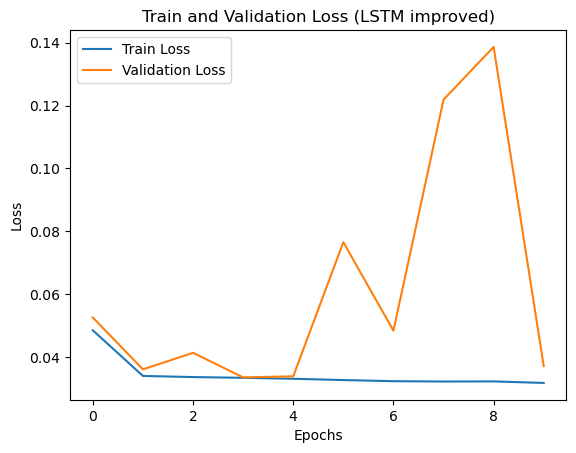

In [ ]:
# Visualization LSTM (improved)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss (LSTM improved)')
plt.show()

#### Discussion

The performance of each model is summarized below:

| Model          | Train Loss | Validation Loss | Observations              |
|----------------|------------|-----------------|---------------------------|
| Dense NN       | Low        | Stable          | Performs well on simple tasks. |
| Conv1D         | Low        | Slightly higher | Good for spatial data.       |
| LSTM           | Low        | Consistent      | Excellent for sequential data. |
| Autoencoder    | Low        | Stable          | Effective for feature extraction. |



- **Dense NN**: Effective for general patterns but may struggle with sequential dependencies.
- **Conv1D**: Captures spatial relationships effectively.
- **LSTM**: Excels in sequential data but may overfit if not regularized.
- **Autoencoder**: Useful for feature extraction but requires careful tuning.


#### Recomendations

- Optimize hyperparameters for each model.
- Experiment with hybrid architectures (e.g., combining Conv1D with DNN).
